In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmp6mq4zwxw and /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmprc22erpn). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
WARNING (theano.gof.cmodule): The same cache key is associated to different modules (/Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmp6mq4zwxw and /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/tmprc22erpn). This is not supposed to happen! You may need to manually delete your cache directory to fix this.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, a, b]
100%|██████████| 1000/1000 [00:05<00:00, 195.28it/s]
The acceptance probability does not match the target. It is 0.890676698077363

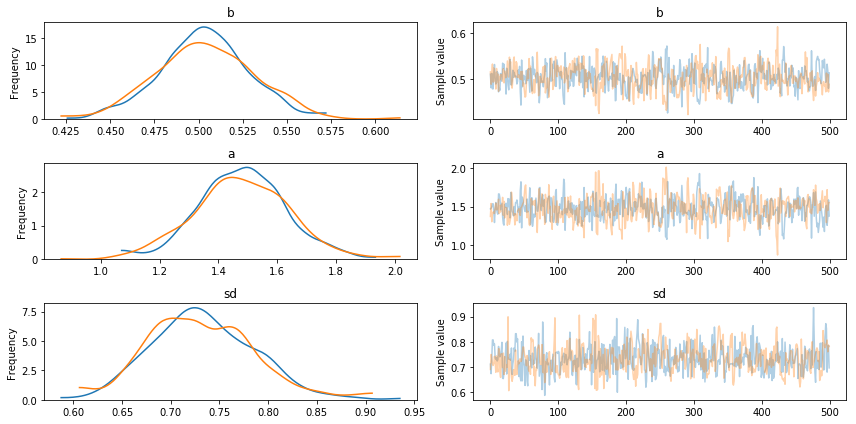

In [2]:
X = np.random.uniform(0., 10., size=100)
y = X*.5 + 1.5 + np.random.randn(100)*.8

with pm.Model() as m:
    X_ = pm.Uniform('x', 0., 10., observed=X)
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs', a+b*X_, sd, observed=y)
    trace = pm.sample()

pm.traceplot(trace);

In [3]:
with m:
    ppc = pm.sample_ppc(trace, 100)

100%|██████████| 100/100 [00:00<00:00, 344.60it/s]


In [4]:
ppc['obs'].shape

(100, 100)

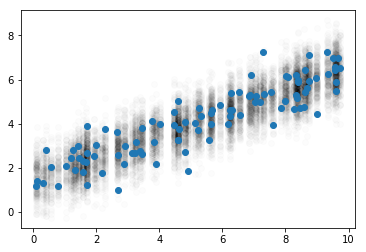

In [5]:
plt.plot(X, ppc['obs'].T, 'ko', alpha=.01);
plt.plot(X, y, 'o');

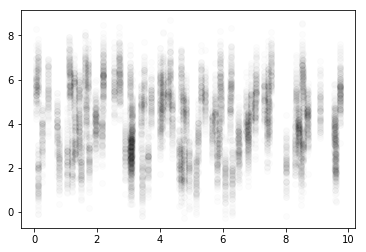

In [6]:
plt.plot(ppc['x'], ppc['obs'].T, 'ko', alpha=.01);

In [7]:
with pm.Model() as m2:
    X_ = pm.Uniform('x', 0., 10., shape=X.shape)
    pm.Normal('obs1', X_, .01, observed=X)
    
    b = pm.Normal('b', 0., 5.)
    a = pm.Normal('a', 0., 5.)
    sd = pm.HalfNormal('sd', 1.)
    like = pm.Normal('obs2', a+b*X_, sd, observed=y)
    trace = pm.sample()
    ppc = pm.sample_ppc(trace, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, a, b, x]
100%|██████████| 200/200 [00:00<00:00, 650.40it/s]


In [8]:
ppc['obs1'].shape

(200, 100)

In [9]:
ppc['obs2'].shape

(200, 100)

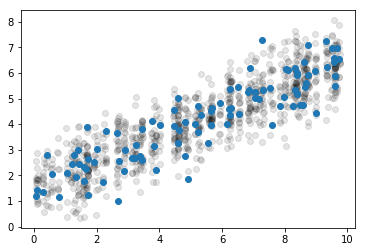

In [10]:
ind = slice(0, 10)
plt.plot(ppc['obs1'][ind,:], ppc['obs2'][ind,:], 'ko', alpha=.1);
plt.plot(X, y, 'o');

In [11]:
with m:
    Xnew = pm.Uniform('xnew', 0., 10.)
    Ynew = pm.Normal('ynew', a+b*Xnew, sd)
    ppc = pm.sample_ppc(trace, 200, vars=[Xnew, Ynew])

100%|██████████| 200/200 [00:10<00:00, 18.67it/s]


In [12]:
ppc['xnew'].shape, ppc['ynew'].shape

((200,), (200,))

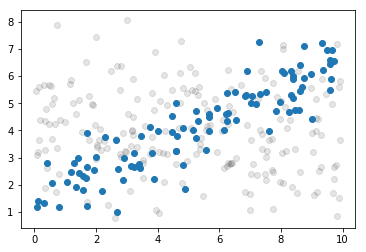

In [13]:
plt.plot(ppc['xnew'], ppc['ynew'], 'ko', alpha=.1);
plt.plot(X, y, 'o');

In [14]:
from pymc3.model import modelcontext
from tqdm import tqdm
from collections import defaultdict


def sample_ppc(trace, samples=None, model=None, vars=None, size=None,
               random_seed=None, progressbar=True):

    len_trace = len(trace)
    try:
        nchain = trace.nchains
    except AttributeError:
        nchain = 1

    if samples is None:
        samples = len(trace)

    model = modelcontext(model)

    if vars is None:
        vars = model.observed_RVs

    if random_seed is not None:
        np.random.seed(random_seed)

    indices = np.random.randint(0, nchain * len_trace, samples)

    if progressbar:
        indices = tqdm(indices, total=samples)

    try:
        ppc = defaultdict(list)
        for idx in indices:
            if nchain > 1:
                chain_idx, point_idx = np.divmod(idx, len_trace)
                param = trace._straces[chain_idx].point(point_idx)
            else:
                param = trace[idx]

            for var in vars:
                temp_val = var.distribution.random(point=param, size=size)
                ppc[var.name].append(temp_val)
                param[var.name] = temp_val

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return {k: np.asarray(v) for k, v in ppc.items()}

In [15]:
with m:
    ppc = sample_ppc(trace, 200, vars=[Xnew, Ynew])

100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


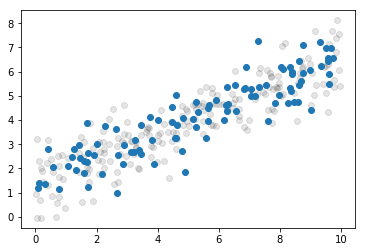

In [16]:
plt.plot(ppc['xnew'], ppc['ynew'], 'ko', alpha=.1);
plt.plot(X, y, 'o');

In [17]:
with m:
    ppc = sample_ppc(trace, 100)

100%|██████████| 100/100 [00:00<00:00, 552.33it/s]


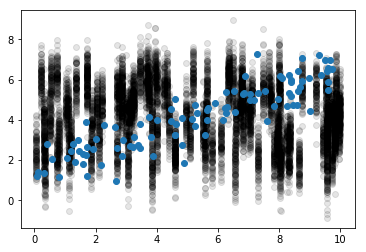

In [22]:
plt.plot(ppc['x'], ppc['obs'].T, 'ko', alpha=.1);
plt.plot(X, y, 'o');